# Машинное обучение, DS-поток
## Задание ML.7


**Правила:**

* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* В каждой задаче не забывайте делать **пояснения и выводы**.


**Правила оформления теоретических задач:**

* Решения необходимо прислать одним из следующих способов:
  * фотографией в правильной ориентации, где все четко видно, а почерк разборчив,
    * отправив ее как файл боту вместе с ноутбуком *или*
    * вставив ее в ноутбук посредством `Edit -> Insert Image` (<font color="red">фото, вставленные ссылкой, не принимаются</font>);
  * в виде $\LaTeX$ в markdown-ячейках.
* Решения не проверяются, если какое-то требование не выполнено. Особенно внимательно все проверьте в случае выбора второго пункта (вставки фото в ноутбук). <font color="red"><b>Неправильно вставленные фотографии могут не передаться при отправке.</b></font> Для проверки попробуйте переместить `ipynb` в другую папку и открыть его там.
* В решениях поясняйте, чем вы пользуетесь, хотя бы кратко. Например, если пользуетесь независимостью, то достаточно подписи вида "*X и Y незав.*"
* Решение, в котором есть только ответ, и отсутствуют вычисления, оценивается в 0 баллов.

**Баллы за задание:**

* Задача 1 &mdash; 30 баллов;

In [89]:
# Bot check

# HW_ID: ds_ml7
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: not final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [90]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.tree import plot_tree
from sklearn.preprocessing import LabelEncoder

import xgboost as xgb
from catboost import CatBoostRegressor
import lightgbm as lgb

from time import time

---

### Задача 1

Рассмотрим данные из задачи ML.6.2. Задача заключается в сравнении моделей градиентного бустинга из sklearn, для которой категориальные признаки закодированы с помощью
* LabelEncoding,
* MeanEncoding.

Какие признаки будете рассматривать? Какие именно преобразования будете совершать?

In [91]:
data_train = pd.read_csv("houses_train.csv")

data_train["date"] = pd.to_datetime(data_train["date"], format="%Y%m%dT%H%M%S")

data_train["date"] = data_train["date"].astype("int64") // 86400 // 10**9

data_train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,3392,16721,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,18295,16778,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,14569,16778,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
3,14081,16849,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
4,6725,16613,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819


In [92]:
data_train.describe()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,15626.000000,15626.000000,1.562600e+04,15626.000000,15626.000000,15626.000000,1.562600e+04,15626.000000,15626.000000,15626.000000,...,15626.000000,15626.000000,15626.000000,15626.000000,15626.000000,15626.000000,15626.000000,15626.000000,15626.000000,15626.000000
mean,10676.101817,16737.365353,5.355339e+05,3.371240,2.111737,2073.132919,1.506655e+04,1.494304,0.007488,0.228465,...,7.649878,1785.817868,287.315052,1970.937028,86.066684,98077.961858,47.559655,-122.213479,1980.853897,12689.631384
std,6186.549696,113.276455,3.595051e+05,0.909872,0.769037,911.406092,4.235533e+04,0.539333,0.086209,0.757528,...,1.171214,821.668484,439.948411,29.368239,405.398690,53.598316,0.138845,0.141089,680.403268,27103.989191
min,0.000000,16557.000000,7.500000e+04,0.000000,0.000000,290.000000,6.000000e+02,1.000000,0.000000,0.000000,...,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,5344.250000,16638.000000,3.200000e+05,3.000000,1.500000,1430.000000,5.060000e+03,1.000000,0.000000,0.000000,...,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.470225,-122.328000,1480.000000,5100.000000
50%,10637.000000,16724.000000,4.500000e+05,3.000000,2.250000,1910.000000,7.598500e+03,1.500000,0.000000,0.000000,...,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571900,-122.230000,1830.000000,7620.000000
75%,16004.500000,16848.000000,6.400000e+05,4.000000,2.500000,2540.000000,1.057975e+04,2.000000,0.000000,0.000000,...,8.000000,2210.000000,550.000000,1996.750000,0.000000,98118.000000,47.678200,-122.124000,2360.000000,10027.000000
max,21434.000000,16948.000000,7.700000e+06,11.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,...,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,5790.000000,871200.000000


Как видим, в нашем датасете присутствуют числовые и временные признаки. 

Также есть категориальные признаки: waterfront и zipcode.

Время сразу переведем в дни, для более удобного подсчета. С категориальными признаками разберемся ниже


Также, в виду сильного перекоса цены, произведем над ней логарифмическую трансформацию

Выполните базовую предобработку данных из задачи ML.6.2

*Совет.* Используйте код из своего решения предыдущего домашнего задания и/или код с семинаров.

С TimeStamp мы справились с самого начала. waterfront уже бинарно зашифрован.

Осталось разобраться с zipcode, также преобразовать цену.

In [93]:
data_train["price"] = np.log(data_train["price"])

Выполните обработку категориальных признаков

Обучите модели и постройте зависимость значения MAPE от количества деревьев и их максимальной глубины.

In [94]:
X, y = data_train, data_train["price"]

ALPHA = 0.75

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=ALPHA, random_state=42)

label_encoder = LabelEncoder()

X_train["zipcode_label"] = label_encoder.fit_transform(X_train["zipcode"])
X_test["zipcode_label"] = label_encoder.transform(X_test["zipcode"])

zipcode_price_mean = X_train.groupby("zipcode")["price"].mean()
X_train["zipcode_mean_encoding"] = X_train["zipcode"].map(zipcode_price_mean)
X_test["zipcode_mean_encoding"] = X_test["zipcode"].map(zipcode_price_mean)

X_train.drop("price", axis=1)
X_test.drop("price", axis=1)

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,zipcode_label,zipcode_mean_encoding
511,19412,16583,4,3.00,2580,209523,2.0,0,0,3,...,0,1984,0,98053,47.6932,-122.006,3440,213444,29,13.306614
3679,19974,16927,2,2.50,1880,40575,1.0,0,0,3,...,0,1987,0,98024,47.5614,-121.899,1930,32935,14,13.317132
11792,8917,16617,4,2.50,1830,9601,2.0,0,0,3,...,0,2003,0,98038,47.3541,-122.015,1830,5892,23,12.760313
6662,20646,16759,3,1.75,3400,46382,1.0,0,0,3,...,1350,1979,0,98053,47.6458,-121.955,2320,20624,29,13.306614
15264,12469,16609,5,3.25,2910,5027,2.0,0,0,3,...,870,2013,0,98106,47.5543,-122.359,2910,5027,44,12.618144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2702,4222,16899,3,2.50,2280,5500,1.5,0,0,3,...,980,1910,0,98117,47.6810,-122.388,1790,5355,51,13.175911
7922,10425,16732,3,1.00,1210,6650,1.0,0,0,3,...,0,1959,0,98008,47.6214,-122.120,990,7590,7,13.235319
14134,16699,16863,3,1.50,1480,9606,1.0,0,0,4,...,380,1964,0,98023,47.2978,-122.363,1600,9619,13,12.576970
331,17314,16913,3,1.50,1250,219978,1.0,0,0,4,...,0,1980,0,98038,47.4056,-121.955,1930,210394,23,12.760313


In [95]:
def plot_dependence_test(
    param_grid, test_values_list, param_labels, metrics_label, title, xlabel, x_axis_scale="linear"
):
    """
    Функция для построения графиков зависимости целевой метрики
    от нескольких параметров модели на валидационной выборке.

    Параметры.
    1) param_grids — список значений исследуемых параметров,
    2) test_values_list — список значений метрики на валидационной выборке,
    3) param_labels — список названий параметров,
    4) metrics_label — название метрики,
    5) title — заголовок для графика.
    """

    colors = ["r", "g", "b", "magenta"]

    plt.figure(figsize=(12, 6))

    if not isinstance(test_values_list, list):
        test_values_list = [test_values_list]
        param_labels = [param_labels]

    for test_values, param_label, color in zip(test_values_list, param_labels, colors):
        plt.plot(
            param_grid, test_values, label=param_label, color=color, alpha=0.7, ls="--"
        )

    plt.ylim((0, None))

    plt.xlabel(xlabel)
    plt.ylabel(metrics_label)

    plt.xscale(x_axis_scale)

    plt.legend()
    plt.title(title)
    plt.show()

def train_and_evaluate_gdb(
    X_train, y_train, X_test, y_test, param_name, param_grid
):
    sklearn_gb_model_values = []

    for param_value in tqdm(param_grid):
        sklearn_gb_model = GradientBoostingRegressor(**{param_name: param_value})
        sklearn_gb_model.fit(X_train, y_train)
        predictions_sklearn_gb = sklearn_gb_model.predict(X_test)
        sklearn_gb_model_values.append(mape(y_test, predictions_sklearn_gb))

    return sklearn_gb_model_values

In [96]:
X_train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,zipcode_label,zipcode_mean_encoding
935,14000,16915,12.906692,3,2.50,1700,4125,2.0,0,0,...,0,2004,0,98065,47.5305,-121.854,1970,4105,34,13.123565
10651,15217,16865,13.567049,3,2.50,2940,15875,2.0,0,0,...,0,1994,0,98075,47.5947,-122.016,2980,15875,38,13.483018
1774,4543,16786,12.629705,3,1.00,1240,6090,1.0,0,0,...,0,1950,0,98155,47.7542,-122.307,1550,9096,62,12.871889
14168,18547,16667,13.337136,3,1.75,1040,5097,1.0,0,0,...,240,1944,0,98199,47.6385,-122.401,1630,5097,69,13.438307
8611,15945,16919,13.679404,3,2.50,2870,13695,2.0,0,0,...,0,1991,0,98052,47.6944,-122.102,2840,8472,28,13.315318


100%|██████████| 200/200 [06:39<00:00,  2.00s/it]


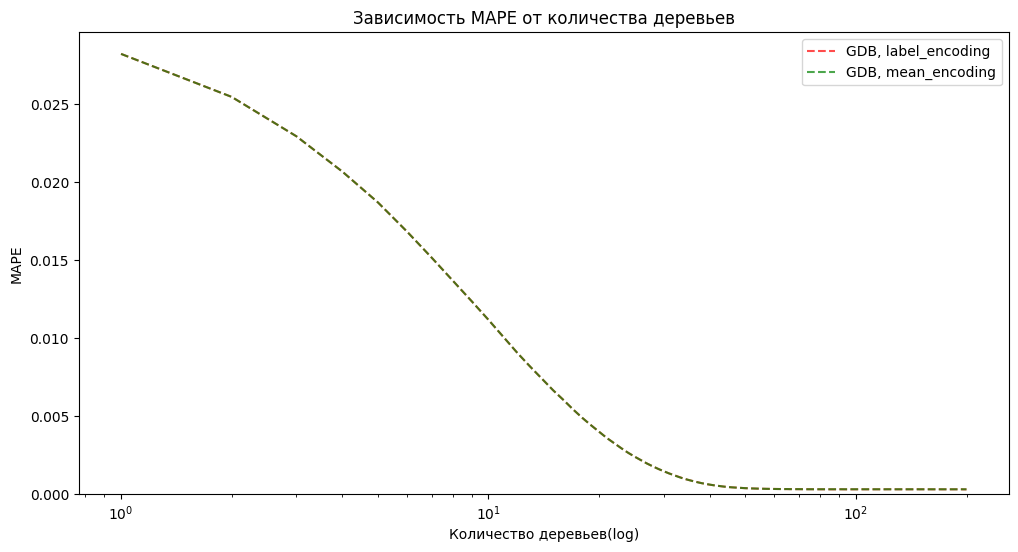

In [97]:
n_estimators_grid = np.arange(1, 201)
gdb_values_labels = train_and_evaluate_gdb(
    X_train.drop(["zipcode", "zipcode_mean_encoding"], axis=1),
    y_train,
    X_test.drop(["zipcode", "zipcode_mean_encoding"], axis=1),
    y_test,
    "n_estimators",
    n_estimators_grid,
)

gdb_values_mean = train_and_evaluate_gdb(
    X_train.drop(["zipcode", "zipcode_label"], axis=1),
    y_train,
    X_test.drop(["zipcode", "zipcode_label"], axis=1),
    y_test,
    "n_estimators",
    n_estimators_grid,
)


plot_dependence_test(
    n_estimators_grid,
    [gdb_values_labels, gdb_values_mean],
    ["GDB, label_encoding", "GDB, mean_encoding"],
    "MAPE",
    "Зависимость MAPE от количества деревьев",
    "Количество деревьев(log)",
    x_axis_scale="log"
)

100%|██████████| 10/10 [00:47<00:00,  4.73s/it]


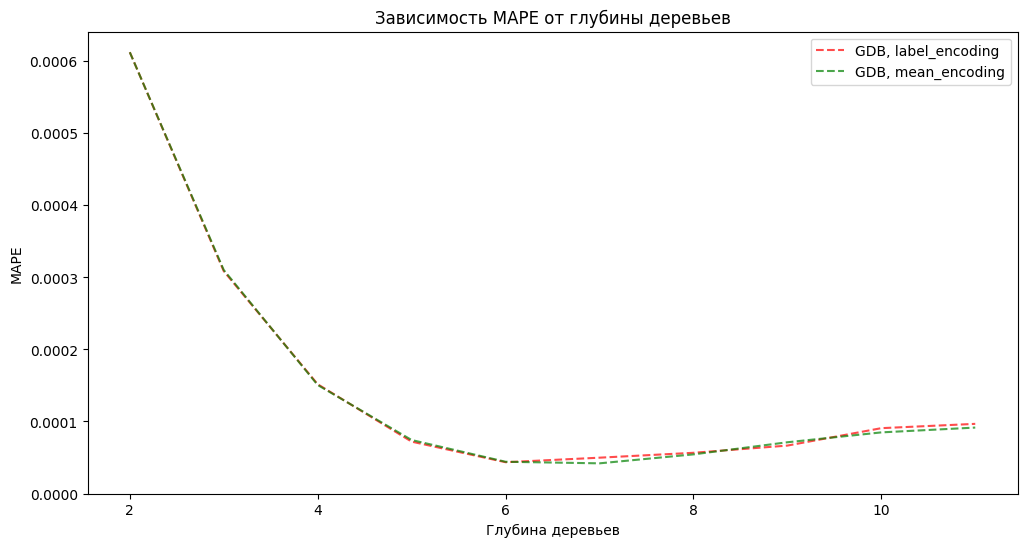

In [98]:
depth_grid = np.arange(2, 12)
gdb_values_labels = train_and_evaluate_gdb(
    X_train.drop(["zipcode", "zipcode_mean_encoding"], axis=1),
    y_train,
    X_test.drop(["zipcode", "zipcode_mean_encoding"], axis=1),
    y_test,
    "max_depth",
    depth_grid,
)

gdb_values_mean = train_and_evaluate_gdb(
    X_train.drop(["zipcode", "zipcode_label"], axis=1),
    y_train,
    X_test.drop(["zipcode", "zipcode_label"], axis=1),
    y_test,
    "max_depth",
    depth_grid,
)


plot_dependence_test(
    depth_grid,
    [gdb_values_labels, gdb_values_mean],
    ["GDB, label_encoding", "GDB, mean_encoding"],
    "MAPE",
    "Зависимость MAPE от глубины деревьев",
    "Глубина деревьев",
)

**Выводы:**

Как видим, результаты MAPE при использовании Label encoding и Mean encoding c категориальными признаками работают примерно примерно одинаково. Тем не менее благодаря обработке, выполненной нами, мы получили результаты MAPE которые намного лучше тех, что были получены в ML.6.2